https://medium.com/geekculture/actor-critic-implementing-actor-critic-methods-82efb998c273

In [1]:
from actor_critic import GACAgent, GraphBasedAgent
import torch
import numpy as np
import grid2op
from grid2op.Action import TopologyChangeAction
from utils import Node, Converter
import numpy as np

c:\Users\Ernest\.conda\envs\l2rpn-test\lib\site-packages\grid2op\Backend\pandaPowerBackend.py:32: UserWarning: Numba cannot be loaded. You will gain possibly massive speed if installing it by 
	c:\Users\Ernest\.conda\envs\l2rpn-test\python.exe -m pip install numba

  warnings.warn(


In [2]:
env_name = "rte_case5_example"  # or any other name.
env = grid2op.make(env_name, test=True, action_class=TopologyChangeAction)

c:\Users\Ernest\.conda\envs\l2rpn-test\lib\site-packages\grid2op\MakeEnv\Make.py:438: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)


In [3]:
obs = env.reset()
converter = Converter(env)
node = Node(env)

In [4]:
action = env.action_space.sample()
print(action, '\n')
print("####################3")
tmp = converter.convert_env_act_to_one_hot_encoding_act(action.to_vect())
print(tmp)
print('\n ################################')
print(converter.convert_one_hot_encoding_act_to_env_act(tmp))

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - NOT force any line status
	 - Switch status of 1 powerlines ([6])
	 - NOT switch anything in the topology
	 - NOT force any particular bus configuration 

####################3
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

 ################################
This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - NOT force any line status
	 - Switch st

In [5]:
HP = {}
HP['alpha'] = 0.0003
HP['input_dim'] = 512
HP['gamma'] = 0.98
HP['fc1'] = 512
HP['fc2'] = 256
HP['n_action'] = 132
HP['node_feature'] = 3
HP['lr'] = 0.0003
agent = GraphBasedAgent(HP)
node = Node(env)
converter = Converter(env)

In [6]:
def int_to_one_hot_encoding(action_nb):
    b = np.zeros((1, HP['n_action']))
    b[np.arange(1), action_nb] = 1
    return b

In [7]:
score_history = []
score = 0
num_episodes = 500
for i in range(num_episodes):
    done = False
    score = 0
    observation = env.reset()
    while not done:
        state, adj = node.convert_obs(observation)
        action = agent.choose_action(state, adj)
        observation_, reward, done, info = env.step(converter.convert_one_hot_encoding_act_to_env_act(int_to_one_hot_encoding(action)))

        next_state, next_adj = node.convert_obs(observation_)
        agent.learn(state, adj, reward, next_state, next_adj, done)
        observation = observation_
        score += reward

        score_history.append(score)
        print('episode: ', i,'score: %.2f' % score)

    filename = 'Lunar-Lander-actor-critic-new-agent-alpha00001-beta00005-2048x512fc-2000games.png'

episode:  0 score: 6.50
episode:  0 score: 13.96
episode:  0 score: 21.49
episode:  0 score: 29.07
episode:  0 score: 36.62
episode:  0 score: 36.62
episode:  1 score: 5.92
episode:  1 score: 5.92
episode:  2 score: 5.99
episode:  2 score: 9.06
episode:  2 score: 12.54
episode:  2 score: 12.54
episode:  3 score: 0.00
episode:  4 score: 7.03
episode:  4 score: 12.49
episode:  4 score: 18.43
episode:  4 score: 18.43
episode:  5 score: 7.57
episode:  5 score: 14.94
episode:  5 score: 22.51
episode:  5 score: 30.06
episode:  5 score: 30.06
episode:  6 score: 5.91
episode:  6 score: 12.55
episode:  6 score: 12.55
episode:  7 score: 4.90
episode:  7 score: 11.95
episode:  7 score: 19.19
episode:  7 score: 26.81
episode:  7 score: 33.58
episode:  7 score: 33.58
episode:  8 score: 4.68
episode:  8 score: 8.95
episode:  8 score: 8.95
episode:  9 score: 5.35
episode:  9 score: 10.65
episode:  9 score: 18.49
episode:  9 score: 26.33
episode:  9 score: 34.17
episode:  9 score: 41.32
episode:  9 sc

In [18]:
np.save("result\\scores_ac.npy", score_history)

In [8]:
agent.save_model("result\\GraphBasedAgent.pth")

In [23]:
import matplotlib.pyplot as plt
def plotLearning(scores, filename, x=None, window=5):   
    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-window):(t+1)])
    if x is None:
        x = [i for i in range(N)]
    plt.ylabel('Score')       
    plt.xlabel('len of episode')                     
    plt.plot(x, running_avg)
    plt.savefig("Shared Graph based Actor Critic")

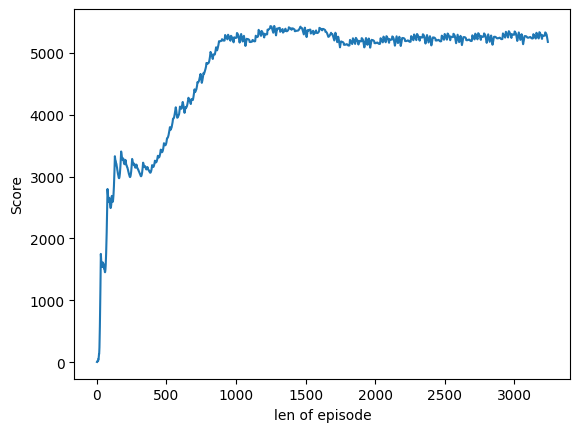

In [24]:
plotLearning(scores_100, filename, window=500)

In [20]:
epochs = list(range(501))
epochs_100 = epochs[::100]
scores_100 = score_history[::100]

# Separate Network

In [7]:
from actor_critic import GACAgent

In [7]:
agent2 = GACAgent(HP)

In [13]:
score_history = []
score = 0
num_episodes = 1500
for i in range(num_episodes):
    done = False
    score = 0
    observation = env.reset()
    while not done:
        state, adj = node.convert_obs(observation)
        action = agent2.choose_action(state, adj)
        observation_, reward, done, info = env.step(converter.convert_one_hot_encoding_act_to_env_act(int_to_one_hot_encoding(action)))

        next_state, next_adj = node.convert_obs(observation_)
        agent2.learn(state, adj, reward, next_state, next_adj, done)
        observation = observation_
        score += reward

        score_history.append(score)
        print('episode: ', i,'score: %.2f' % score)

    filename = 'Lunar-Lander-actor-critic-new-agent-alpha00001-beta00005-2048x512fc-2000games.png'

episode:  0 score: 0.00
episode:  1 score: 5.08
episode:  1 score: 9.92
episode:  1 score: 9.92
episode:  2 score: 5.59
episode:  2 score: 13.31
episode:  2 score: 13.31
episode:  3 score: 6.02
episode:  3 score: 12.02
episode:  3 score: 16.75
episode:  3 score: 16.75
episode:  4 score: 6.87
episode:  4 score: 6.87
episode:  5 score: 6.81
episode:  5 score: 6.81
episode:  6 score: 4.27
episode:  6 score: 10.08
episode:  6 score: 16.35
episode:  6 score: 16.35
episode:  7 score: 7.77
episode:  7 score: 15.59
episode:  7 score: 15.59
episode:  8 score: 4.16
episode:  8 score: 4.16
episode:  9 score: 7.66
episode:  9 score: 15.16
episode:  9 score: 22.59
episode:  9 score: 30.22
episode:  9 score: 36.21
episode:  9 score: 43.99
episode:  9 score: 51.75
episode:  9 score: 57.89
episode:  9 score: 65.39
episode:  9 score: 71.07
episode:  9 score: 77.93
episode:  9 score: 84.36
episode:  9 score: 90.81
episode:  9 score: 90.81
episode:  10 score: 4.20
episode:  10 score: 8.58
episode:  10 sc

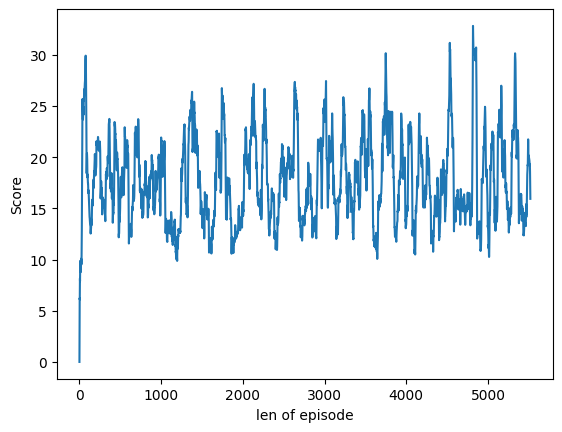

In [14]:
plotLearning(score_history, "result\\2-ac-graph-rl.png", window=50)

In [11]:
def int_to_onehot(n, n_classes):
    v = [0] * n_classes
    v[n] = 1
    return np.array(v)

In [13]:
from tqdm.notebook import tqdm

all_obs = []
obs = env.reset()
all_obs.append(obs)
reward = env.reward_range[0]
reward_list = []
done = False
nb_step = 0
print("Very Graph based Actor Critic Simulation")
with tqdm(total=env.chronics_handler.max_timestep()) as pbar:
    state, adj = node.convert_obs(obs)
    while True:
        action = agent.choose_action(state, adj)
        #action = my_agent.act(obs, reward, done)
        obs, reward, done, _ = env.step(converter.convert_one_hot_encoding_act_to_env_act(int_to_onehot(action, 132)))
        reward_list.append(reward)
        pbar.update(1)
        if done:
            break
        all_obs.append(obs)
        nb_step += 1

reward_list_simple_DQN = np.copy(reward_list)

Very Graph based Actor Critic Simulation


  0%|          | 0/2016 [00:00<?, ?it/s]